## Long Term Memory - Memory Store

Storing the Memory of the users for long term using the Langgraph Store API

LangGraph stores long-term memories as JSON documents in a store. Each memory is organized under a custom namespace (similar to a folder) and a distinct key (like a file name). Namespaces often include user or org IDs or other labels that makes it easier to organize information.

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langgraph.store.sqlite import SqliteStore
from langgraph.store.base import BaseStore

Create the Store with Sqlite

In [2]:
import sqlite3
from sqlite3 import Connection

connection: Connection = sqlite3.connect("store.db",check_same_thread=False,isolation_level=None)
# Initialize the SQLite store
store= SqliteStore(connection)

When storing objects (e.g., memories) in the Store, we provide:

- The namespace for the object, a tuple (similar to directories)
- the object key (similar to filenames)
- the object value (similar to file contents)

We use the put method to save an object to the store by namespace and key.

In [3]:
user_id = '12'
namespace_for_memory = (
    user_id,
    "chat_memory",
)  # Tuple representing user-specific namespace
key = "conversation_1"  # Unique key for storing in the store
value = {"food": "Pizza", "name": "John Doe"}  # Data to be stored

Store in the database

In [4]:
store.put(namespace_for_memory,key,value)

Searching or getting the list of the namespace present in the store

In [5]:
store.get(namespace_for_memory,key)

Item(namespace=['12', 'chat_memory'], key='conversation_1', value={'food': 'Pizza', 'name': 'John Doe'}, created_at='2025-12-02T22:52:40', updated_at='2025-12-02T22:52:40')

List the Namespaces

In [6]:
store.list_namespaces()

[('1', 'chat_memory'), ('12', 'chat_memory')]

Search the values 

In [7]:
store.search(namespace_for_memory,query="food")

[Item(namespace=['12', 'chat_memory'], key='conversation_1', value={'food': 'Pizza', 'name': 'John Doe'}, created_at='2025-12-02T22:52:40', updated_at='2025-12-02T22:52:40', score=None)]

### Chatbot with Long-Term Memory

Creating the Instance of the LLM Model

In [8]:
llm_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", temperature=0, include_thoughts=False
)

Creating the simple Converstation Chatbot

In [12]:
system_prompt_assistant="""
You are a helpful assistant that helps users with their questions. If you have the details or memory regarding the user, use that to answer the question.
Here is the Memory: {memory}
"""


system_prompt_gather="""
You are an assistant that helps gather information about the user to store in memory, For Personalizing the user experience.
Current User Information: {memory}
Based on the Chat History, extract the informmation like the below
INSTRUCTIONS:
1. Review the Chat History Carefully.
2. Identify any new information about the user that can be added to the memory, apart from the provided memory. 
3. format the memory as a clear, bulleted list.
4. If no new information is found, return the existing memory as is.
"""

In [13]:
from langgraph.graph import MessagesState
from langchain_core.runnables import RunnableConfig
from langchain.messages import SystemMessage


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["userid"]

    # Retrieve the memory from the store
    namespace_for_memory = (
        user_id,
        "chat_memory",
    )
    key = f"memory"
    existing_memory = store.get(namespace_for_memory, key)
    if existing_memory:
        memory_str = existing_memory.value.get("memory")
    else:
        memory_str = "No prior memory found."

    prompt_template = system_prompt_assistant.format(memory=memory_str)
    response = llm_model.invoke(
        [SystemMessage(content=prompt_template)] + state["messages"]
    )
    return {"messages": response}

In [23]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["userid"]

    # Retrieve the memory from the store
    namespace_for_memory = (
        user_id,
        "chat_memory",
    )
    key = f"memory"
    existing_memory = store.get(namespace_for_memory, key)
    if existing_memory:
        memory_str = existing_memory.value.get("memory")
    else:
        memory_str = "No prior memory found."

    prompt_template = system_prompt_gather.format(memory=memory_str)
    response = llm_model.invoke(
        [SystemMessage(content=prompt_template)] + state["messages"]
    )
    print(response.content)
    store.put(namespace_for_memory,key,{"memory": response.content})

Creating the graph

In [24]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

graph = StateGraph(MessagesState)
graph.add_node("call_model", call_model)
graph.add_node("write_memory", write_memory)

graph.add_edge(START, "call_model")
graph.add_edge("call_model", "write_memory")
graph.add_edge("write_memory", END)

# Passing the Store
compiled_graph = graph.compile(store=store, checkpointer=memory)

Display the graph

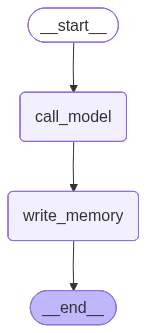

In [25]:
from IPython.display import display,Image

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

Let's test out these how it works. 

In [26]:
from langchain.messages import HumanMessage

config = {"configurable": {"thread_id": "1", "userid": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance, it's great to meet you! I'll remember your name. How can I help you today?
- The user's name is Lance.


Let's Check what is stored in the Store

In [27]:
store.list_namespaces()

[('1', 'chat_memory'), ('12', 'chat_memory')]

In [28]:
config = {"configurable": {"thread_id": "1", "userid": "1"}}

# User input 
input_messages = [HumanMessage(content="I Stays in the Europe for Study Purposes")]

# Run the graph
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I Stays in the Europe for Study Purposes
================================== Ai Message ==================================

Thanks for letting me know, Lance! That's interesting. Studying in Europe sounds like a great experience.

Is there anything specific you'd like to discuss about your studies or life in Europe, or anything else I can help you with?
Here's the updated user information:

*   The user's name is Lance.
*   The user lives in Europe for study purposes.


In [29]:
store.get(('1', 'chat_memory'),"memory")

Item(namespace=['1', 'chat_memory'], key='memory', value={'memory': "Here's the updated user information:\n\n*   The user's name is Lance.\n*   The user lives in Europe for study purposes."}, created_at='2025-12-02T22:59:35', updated_at='2025-12-02T22:59:35')

Reusing the Memory on our Second Thread as these was the same Thread

In [30]:
config = {"configurable": {"thread_id": "2", "userid": "1"}}

# User input 
input_messages = [HumanMessage(content="Can you tell me my name and all my details?")]

# Run the graph
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you tell me my name and all my details?
================================== Ai Message ==================================

Hello Lance!

Here are the details I have for you:

*   **Name:** Lance
*   **Location:** You live in Europe for study purposes.



## Memory Schema and Complex Structuring

In langchain or langgraph when we invoke the model with structured output there is possibility that it might get failed to extract the output, to encounter and solve these issue, langchain team created module named `trustcall` which patch the json output for huge and complex schema. 

As we know that llm model can't structure the complex schemas, to solve these issue the trustcall module is used to extract the structured output. Let's see that in action

Defining the Complex Schema

In [31]:
from pydantic import BaseModel, Field

class UserProfile(BaseModel):
    name: str = Field(description="Name of the User")
    location: str = Field(description="Location of the User")
    interests: list[str] = Field(description="Interests of the User")

However the schema which we have created can be easily converted to structured output by LLM model. 

Storing these schema into the store

In [32]:
namespace=("trial",)
key="user_profile"
value=UserProfile(name="Lance",location="Europe",interests=["Studying","Traveling"]).model_dump()

In [33]:
store.put(namespace,key,value)

In [34]:
store.list_namespaces()

[('1', 'chat_memory'), ('12', 'chat_memory'), ('trial',)]

In [36]:
store.get(namespace,key).value

{'name': 'Lance', 'location': 'Europe', 'interests': ['Studying', 'Traveling']}

Convert the value to the appropriate Pydantic Model

In [38]:
userprofile = UserProfile.model_validate(store.get(namespace,key).value)
userprofile

UserProfile(name='Lance', location='Europe', interests=['Studying', 'Traveling'])

Let's try out how trust call is gonna work for 

In [39]:
from trustcall import create_extractor

In [43]:
llm_model_with_schema = llm_model.with_structured_output(UserProfile)

Create the extractor by passing the LLM Model, tools choice and appropriate tools. 

In [44]:
bound = create_extractor(
    llm=llm_model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

Creating the Sample Messages

In [46]:
from langchain_core.prompts import ChatPromptTemplate

prompts = ChatPromptTemplate.from_messages(
    messages=[
        (
            "system",
            "Extract the user profile information from the following conversation.",
        ),
        ("human", "Hello my name is alice"),
        ("human", "I live in Wonderland and I love adventures."),
        ("human", "I love to eat cakes and explore new places."),
        ("human", "but i hate getting lost."),
    ]
)

Invoke the extractor

In [51]:
value = prompts.invoke({})

In [ ]:
from trustcall._base import ExtractionOutputs

response: ExtractionOutputs = bound.invoke(value)
response

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'UserProfile', 'arguments': '{"interests": ["adventures", "eating cakes", "exploring new places"], "location": "Wonderland", "name": "alice"}'}, '__gemini_function_call_thought_signatures__': {'d5eeaebd-c1f0-4858-a75a-e89c54e56317': 'CpoFAXLI2ny1Gc+w66+lWC5AE4TZr6YyyM2Edh/uvE6zI7WRTbe94CLc1cqBC67ATlhApDkr7+qwZkNUpRuah4XsNicjl0iYYz2TdZ9O9a6aucmYbaTkl60dk6aqmsmgBERBosUxRDoONUPwbhAEGdIe5nk59uPN9rIp9DjYNM1HzE4OrhlPo6jnfC0EkjX3SRQVwCULpB6VWfsFXRDB1Igpzv2rv6kIo+Oe+6b3lbj1vRxPr7X0mxDmJJFpoMAYQpKeCPihA+8t5Gx37ML1Vbmxj5cj1RkL0RhxRerEF+loLOKaNRryF60pkgCiLM5JxUU6pkgmqsFk9axUFgaM38AYRndqrXmampGi2f7Er5ZOxa7YRGZsmUmuQcTE12KvKjT9R6vy2i3nkEi6H7fZvvOWGElsJwlgBL5W1ok2EA8jg1xauCruvzuuk4cRxm+VlgWKp2qOtHsuq73bRYNk684LMeyPlH66OcC/QuTeEdLTknNBrpa3/SWJWBixaAQC0pVlsc4QDzreumnyB2YKWKAGVQdckNJS4VO4D7/3zCGz4n+RCboP1NTx9nqnEQMHuiX5HAvCN7pgAJmg5Oi7X5iGEZTyRJzEkphb8jUv3O36RrEms9/IMxHAoLHzo+BZ/RF1s/e8wOmd9JUUFFP9sMXGxvYDddxj8P4xVkA/zBWDq

In [54]:
response['responses'][0]

UserProfile(name='alice', location='Wonderland', interests=['adventures', 'eating cakes', 'exploring new places'])

Similar things we can do with the chatbot model we created in previous section with the memory. 